In [1]:
import numpy as np   # Importo paquete de álgebra lineal
import matplotlib.pyplot as plt   # Importo paquete de gráficos
import copy
import mef
plt.rc('figure', figsize=(15,8))   # Para gráficos
plt.rc('font',size=22)             # Para gráficos

## Punto 1

Determine los **desplazamientos** de los bordes libres y los **esfuerzos** en función de la posición para la placa empotrada mostrada en la figura. Tome las dos particiones en elementos mostradas debajo [$a)$ y $b)$] y compare los resultados. Asuma que $E = 30 x 10^{6}\: psi$ y $\nu = 0,30$.

<center><img src="ImgProb01.png"></center>

In [2]:
# Defino los grados de libertad por nodo "glxn".
glxn = 2

In [3]:
# Defino el módulo de elasticidad "E" de la viga.
E = 30e6   # psi=lb/in^2

# Defino módulo de Poisson "nu".
nu = 0.3

# Defino la longitud "L" .
L = 20   # in

# Defino la altura "h" .
h = 10   # in

# Defino espesor "t"
t = 1

# Defino el valor de la carga distribuida "T".
T = 1000   # psi=lb/in^2

In [4]:
# Matriz "D" que relaciona tensores tensión-deformación, para problema de tensiones planas.
D = (E/(1-(nu**2)))*np.array([[1,nu,0],
                              [nu,1,0],
                              [0,0,0.5*(1-nu)]])

In [5]:
# Defino la matriz de nodos "MN".
# - Columna 1 es la coordenada "x" del nodo.
# - Columna 2 es la coordenada "y" del nodo.
# - Columna 3 es la coordenada "z" del nodo.
MN = np.array([[0,0,0],
               [0,h,0],
               [L,h,0],
               [L,0,0]])

# Su número de filas es el número de NODOS "Nn".
Nn = MN.shape[0]

In [6]:
# Defino la matriz de conectividad "MC".
# Informa qué nodos componen a cada elemento.
MC= np.array([[0,2,1],
              [0,3,2]])

# Su número de filas es el número de ELEMENTOS "Ne".
# Su número de columnas es el número NODOS POR ELEMENTO "Nnxe".
Ne, Nnxe = MC.shape

In [7]:
# Defino vector "A" que almacena área de cada elemento.
A = np.zeros(Ne)

# Defino "alpha", "beta" y "gamma" para cada elemento.
alpha = np.zeros([3,Ne])
beta = np.zeros([3,Ne])
gamma = np.zeros([3,Ne])

# Defino diccionario en el que se almacenará, para cada elemento, la matriz "B" que relaciona deformación-desplazamiento.
B = {}

# Defino diccionario en el que se almacenará, para cada elemento, la matriz elemental "Ke".
Ke = {}

# Calculo las áreas orientadas, GENERALIZADO, usando producto vectorial.
for e in range(Ne):
    nodos = MC[e,:] # Guarda los nodos del elemento "e".
    alpha[0,e] = MN[nodos[1],0]*MN[nodos[2],1] - MN[nodos[2],0]*MN[nodos[1],1]
    alpha[1,e] = MN[nodos[0],0]*MN[nodos[2],1] - MN[nodos[2],0]*MN[nodos[0],1]
    alpha[2,e] = MN[nodos[0],0]*MN[nodos[1],1] - MN[nodos[1],0]*MN[nodos[0],1]
    beta[0,e] = MN[nodos[1],1]-MN[nodos[2],1]  # "1" es Y
    beta[1,e] = MN[nodos[2],1]-MN[nodos[0],1]
    beta[2,e] = MN[nodos[0],1]-MN[nodos[1],1]
    gamma[0,e] = MN[nodos[2],0]-MN[nodos[1],0]  # "0" es X
    gamma[1,e] = MN[nodos[0],0]-MN[nodos[2],0]
    gamma[2,e] = MN[nodos[1],0]-MN[nodos[0],0]
    A[e] = (alpha[0,e] - alpha[1,e] + alpha[2,e])/2
    B[e] = (1/(2*A[e]))*np.array([[beta[0,e],0,beta[1,e],0,beta[2,e],0],
                            [0,gamma[0,e],0,gamma[1,e],0,gamma[2,e]],
                            [gamma[0,e],beta[0,e],gamma[1,e],beta[1,e],gamma[2,e],beta[2,e]]])
    Ke[e] = t*np.abs(A[e])*np.transpose(B[e]).dot(D.dot(B[e]))

In [8]:
# Defino matriz global "Kg".
Kg = np.zeros([glxn*Nn, glxn*Nn])

# Ensamblo las matrices elementales "Ke" para obtener la matriz global "Kg".
for e in range(Ne): 
    for i in range(Nnxe):
        rangoi = np.linspace(i*glxn, (i+1)*glxn-1, Nnxe).astype(int)
        rangoni = np.linspace(MC[e, i]*glxn, (MC[e, i]+1)*glxn-1, Nnxe).astype(int)
        for j in range(Nnxe):
            rangoj = np.linspace(j*glxn, (j+1)*glxn-1, Nnxe).astype(int)
            rangonj = np.linspace(MC[e, j]*glxn, (MC[e, j]+1)*glxn-1, Nnxe).astype(int)
            Kg[np.ix_(rangoni, rangonj)] += Ke[e][np.ix_(rangoi, rangoj)]

**Generalización de vector $s$ con condiciones de vínculo en desplazamiento:** Debo barrer los nodos (uso FOR) y preguntar cuáles se encuentran en el extremo empotrado, es decir, cuáles tienen asignada posición $x = 0$. Al haber $glxn = 2$, por cada nodo empotrado se agregarán dos componentes al vector $s$.

In [9]:
# Generalizo obtención de vector "s", y condiciones de vínculo "Us".
def empotrado(MN,glxn):
    Nn = MN.shape[0]   # Número de NODOS.
    s = []   # Guarda coordenadas X,Y de los nodos empotrados. No Z.  
    for n in range (Nn):
        if MN[n,0] == 0:
            s.append(glxn*n) # Guardo coordenada X.
            s.append(glxn*n + 1) # Guardo coordenada Y.
    Us = np.zeros_like(s).reshape([-1,1]) # Vector NULO con condiciones de vínculo en desplazamientos.
    return s, Us

In [10]:
# Obtengo vector "s" que contiene los nodos con condiciones de vínculo en desplazamiento.
# Obtengo vector "Us" con los valores de las condiciones de vínculo.
s, Us = empotrado(MN,glxn)

# Defino vector "r" que contiene los nodos con condiciones de vínculo en fuerza. Es el complemento de "s".
r = np.array([i for i in range(Nn*glxn) if i not in s])

**Generalización de vector $f$ con fuerzas aplicadas sobre los nodos:** Según la cantidad de nodos del sistema, habrán algunos en el extremo traccionado y otro no. Aquellos que no, tendrán una fuerza aplicada NULA. Aquellos que sí, tendrán aplicada una fuerza que resultará de distribuir la carga distribuida $T$ sobre todos ellos.

Debo barrer los elementos (uso FOR) y preguntar cuáles poseen dos (de sus tres) nodos en el extremo traccionado. Luego debo calcular la distancia $dist$ entre aquellos nodos (en el eje Y), y sabiendo la carga distribuida $T$ y el espesor de chapa $t$ calculo la fuerza $T.t.dist/2$ que se distribuye sobre aquellos dos nodos.

In [11]:
def traccionados(MC, MN, glxn,L,T,t):
    Ne, Nnxe = MC.shape   # Número de ELEMENTOS y número de NODOS POR ELEMENTO.
    Nn = MN.shape[0]      # Número de NODOS.
    # Defino vector "f" que almacenará, para aquellos elementos que posean 2 nodos en el extremo traccionado (x=L), las
    # fuerzas distribuidas entre aquellos 2 nodos. 
    f = np.zeros(glxn*Nn)   # Tracción es sólo en X. Las componentes Y son NULAS.
    for e in range(Ne):
        nodo1= MC[e,0]
        nodo2= MC[e,1]
        nodo3= MC[e,2]
        if MN[nodo1,0] == L:
            # El elemento "e" ya posee un nodo en el extremo empotrado.
            if MN[nodo2,0] == L:
                # El elemento "e" posee DOS nodos en el extremo empotrado.
                dist = np.abs(MN[nodo2,1] - MN[nodo1,1])  # Distancia entre nodos, en el eje Y.
                f[nodo1*glxn] = T*t*dist/2
                f[nodo2*glxn] = T*t*dist/2
            elif MN[nodo3,0] == L:
                # El elemento "e" posee DOS nodos en el extremo empotrado.
                dist = np.abs(MN[nodo3,1] - MN[nodo1,1])  # Distancia entre nodos, en el eje Y.
                f[nodo1*glxn] = T*t*dist/2
                f[nodo3*glxn] = T*t*dist/2
        elif MN[nodo2,0] == L:
            # El elemento "e" ya posee un nodo en el extremo empotrado.
            if MN[nodo3,0] == L:
                # El elemento "e" posee DOS nodos en el extremo empotrado.
                dist= np.abs(MN[nodo3,1] - MN[nodo2,1])  # Distancia entre nodos, en el eje Y.
                f[nodo2*glxn]= T*t*dist/2
                f[nodo3*glxn]= T*t*dist/2
    return f

In [12]:
# Obtengo vector "f" de tamaño "glxn*Nn", que almacena las fuerzas aplicadas sobre los nodos luego de distribuir la 
# carga distribuida "T" entre ellos.
# - En posiciones pares almacena fuerzas en Y. Serán NULAS, ya que no se tracciona en esa dirección.
# - En posiciones impares almacena fuerzas en X. No serán nulas, salvo que se trate de un nodo no traccionado.
f = traccionados(MC, MN, glxn,L,T,t)

# Defino vector "Fr" con los valores de las condiciones de vínculo.
Fr = np.array([[f[i]] for i in r])

In [13]:
# Llamo al paquete "mef", que contiene la función "solve" que calcula los vectores de fuerzas y torques "F", y de 
# desplazamientos y rotaciones "U", empleando MEF. 
F, U = mef.solve(Kg, r, Fr, s, Us)

In [14]:
print('Las FUERZAS (en lb) son:')
print(F)
print('Los DESPLAZAMIENTOS (en in) son:')
print(U)

Las FUERZAS (en lb) son:
[[-5000.        ]
 [-3002.40192154]
 [-5000.        ]
 [ 3002.40192154]
 [ 5000.        ]
 [    0.        ]
 [ 5000.        ]
 [    0.        ]]
Los DESPLAZAMIENTOS (en in) son:
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.09580998e-04]
 [4.16333066e-06]
 [6.63704297e-04]
 [1.04083267e-04]]


In [15]:
# Cálculo de tensiones.
desp_xy = U.reshape(Nn,2)
desp_xyz = np.hstack([desp_xy,np.zeros([Nn,1])])

In [16]:
# Calculo las posiciones finales de los nodos, matriz "MN_final".
MN_final = MN + desp_xyz

In [17]:
# Almacena desplazamientos de cada elemento.
desp_elem = {}
tensión = {}
for e in range(Ne):
    desp_elem[e] = desp_xyz[MC[e],:2].ravel().reshape(-1,1)   # "2" así no me toma Z
    tensión[e] = D.dot(B[e].dot(desp_elem[e])) 

In [18]:
print('La TENSIÓN (en psi) en cada elemento es:')

La TENSIÓN (en psi) en cada elemento es:


In [19]:
tensión

{0: array([[1004.80384307],
        [ 301.44115292],
        [   2.40192154]]),
 1: array([[995.19615693],
        [ -1.20096077],
        [ -2.40192154]])}

## Gráfico del ANTES y DESPUÉS de la chapa

No se nota la diferencia porque debería hacer como Lucho, que al definir "MN_final" sumó "1e4*desp_xyz" en vez de sólo "desp_xyz", así se nota más la diferencia entre antes y después.

Text(0.5, 0, 'y (in)')

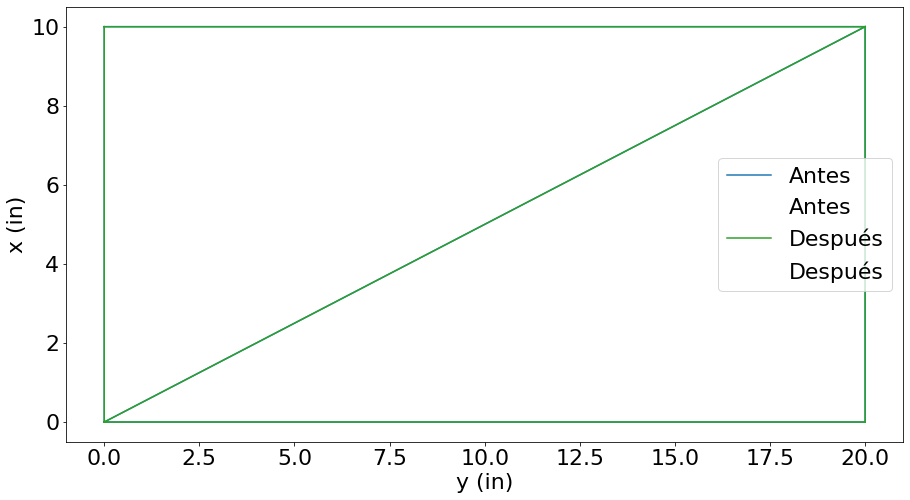

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
plt.triplot(MN[:,0], MN[:,1], MC, label='Antes')
plt.triplot(MN_final[:,0], MN_final[:,1], MC, label='Después')
plt.legend()
plt.ylabel('x (in)')
plt.xlabel('y (in)')

## Gráfico de FUERZAS en los nodos

Text(0, 0.5, 'y (in)')

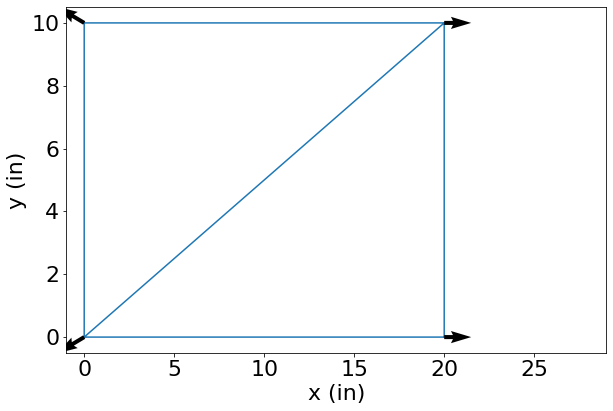

In [21]:
# Separo componentes de fuerza en X y en Y.
Fx = F[2*np.arange(Nn)]
Fy = F[2*np.arange(Nn)+1]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
ax.triplot(MN[:,0],MN[:,1],MC-MC.min(), )
ax.quiver( MN[:,0], MN[:,1], Fx, Fy, linewidth=5, units='width', scale=1e5)   # Flechas
ax.set_xlim(-1, 1.2*L+(Fx/1e3).max())
ax.set_xlabel('x (in)')
ax.set_ylabel('y (in)')

## Gráfico de DESPLAZAMIENTOS en los nodos

Text(0, 0.5, 'y (in)')

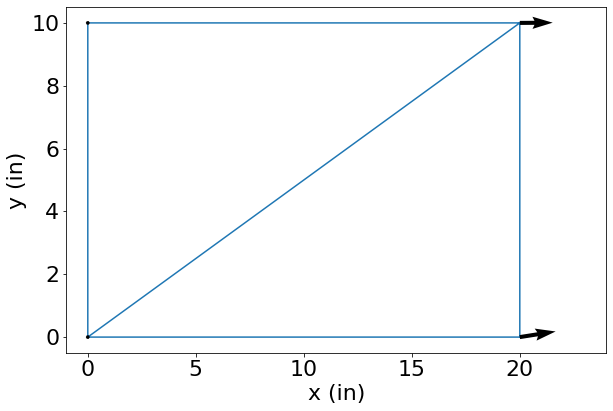

In [22]:
# Separo componentes de desplazamiento en X y en Y.
Ux = U[2*np.arange(Nn)]
Uy = U[2*np.arange(Nn)+1]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
ax.triplot(MN[:,0],MN[:,1],MC-MC.min(), )
ax.quiver( MN[:,0], MN[:,1], Ux*1e7, Uy*1e7, linewidth=5, units='width', scale=1e5)   # Flechas
ax.set_xlim(-1, 1.2*L+(Ux/1e3).max())
ax.set_xlabel('x (in)')
ax.set_ylabel('y (in)')

Notar la asimetría en desplazamientos. Se debe al tipo de mallado utilizado.